## Loading the dataset
- Labels are a 15x7 grid of values


In [1]:
# python imaging library
from PIL import Image
# importing pytorch transforms to build a pipeline
from torchvision import transforms

image = Image.open("/projects/mystery-app/datasets/provided-examples/images/Cats-L1-1_jpg.rf.267d65552389bf732039988c367ba326.jpg")

# Converts the image to a PyTorch tensor (C x H x W)
# and normalizes pixel values to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()
])

img_tensor = transform(image)
print(img_tensor.size())


torch.Size([3, 640, 640])


- We should save the paths to each file in a list. Then the function __getitem__ will simply use the transformers on the image and it's label, then it will return them as tensors

In [2]:
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataset_path, image_dir, labels_dir):
        # This has to be changed to read everything in the labels directory.
        self.dataset_path = dataset_path
        self.image_file_names = os.listdir(image_dir)
        self.label_file_names = os.listdir(labels_dir)
    
    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        image_path = self.image_file_names[index]
        image = transform(Image.open(os.path.join(self.dataset_path, "images/", image_path)))
        label = self.label_transformer(self.dataset_path+"labels/"+self.label_file_names[index])
        return image, label

    def label_transformer(self, label_path):
        print(label_path)
        df = pd.read_csv(label_path, sep='\s+', header=None, lineterminator='\n')
        print(df.values)
        return torch.tensor(df.values)


        

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2081519/2069852735.py:29: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(label_path, sep='\s+', header=None, lineterminator='\n')


In [3]:

transformer = transforms.Compose([
  transforms.ToTensor()
])

images = CustomImageDataset(
    "/projects/mystery-app/datasets/provided-examples/",
    "/projects/mystery-app/datasets/provided-examples/images",
    "/projects/mystery-app/datasets/provided-examples/labels",
)
images.__getitem__(10)

/projects/mystery-app/datasets/provided-examples/labels/Cats-L1-3_jpg.rf.64368d684ea1359ab0dd1a1c77fb5346.txt
[[0.        0.5828125 0.21875   0.2375    0.334375 ]]


(tensor([[[0.6549, 0.6431, 0.6353,  ..., 0.8235, 0.6431, 0.5412],
          [0.6471, 0.6431, 0.6392,  ..., 0.6471, 0.5451, 0.4824],
          [0.6510, 0.6549, 0.6549,  ..., 0.5059, 0.4941, 0.4510],
          ...,
          [0.5098, 0.5176, 0.5255,  ..., 0.3412, 0.3647, 0.3882],
          [0.5098, 0.5137, 0.5176,  ..., 0.3451, 0.3765, 0.3961],
          [0.5176, 0.5176, 0.5176,  ..., 0.3490, 0.3882, 0.4039]],
 
         [[0.5098, 0.4980, 0.4902,  ..., 0.7608, 0.5608, 0.4510],
          [0.5020, 0.4980, 0.4941,  ..., 0.5804, 0.4627, 0.3922],
          [0.5059, 0.5098, 0.5098,  ..., 0.4431, 0.4157, 0.3647],
          ...,
          [0.4000, 0.4078, 0.4157,  ..., 0.2471, 0.2784, 0.3098],
          [0.4118, 0.4157, 0.4196,  ..., 0.2627, 0.2980, 0.3294],
          [0.4196, 0.4196, 0.4196,  ..., 0.2706, 0.3098, 0.3373]],
 
         [[0.3451, 0.3333, 0.3255,  ..., 0.6627, 0.4471, 0.3294],
          [0.3373, 0.3333, 0.3294,  ..., 0.4706, 0.3412, 0.2588],
          [0.3412, 0.3451, 0.3451,  ...,

## Making predictions


/projects/mystery-app/mystery-app-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/projects/mystery-app/mystery-app-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/projects/mystery-app/datasets/provided-examples/labels/test-L1-194_jpg.rf.ac8a0670305c317b8bf042d50dfdc947.txt
[[0.      0.5625  0.50625 0.8     0.85   ]]


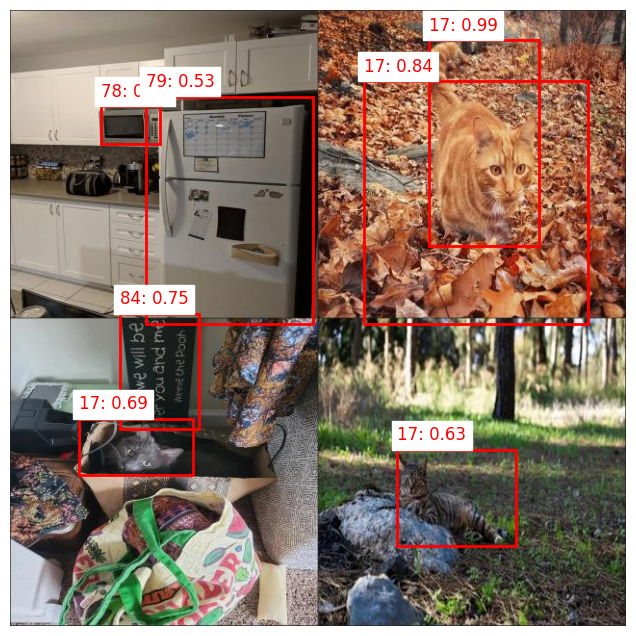

In [5]:
import torch.nn as nn

from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
sample = images.__getitem__(20)
img_tensor = sample[0].unsqueeze(0)
res = model(img_tensor)
res

# Extract boxes, labels, and scores from the result
boxes = res[0]['boxes'].detach().numpy()  # Bounding box coordinates
scores = res[0]['scores'].detach().numpy()  # Confidence scores
labels = res[0]['labels'].detach().numpy()  # Class labels

# Confidence threshold
confidence_threshold = 0.5
filtered_indices = scores > confidence_threshold
boxes = boxes[filtered_indices]
scores = scores[filtered_indices]
labels = labels[filtered_indices]

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(sample[0].permute(1, 2, 0))  # Convert CHW to HWC for plotting

# Add bounding boxes
for box, score, label in zip(boxes, scores, labels):
    x_min, y_min, x_max, y_max = box
    width, height = x_max - x_min, y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 10, f"{label}: {score:.2f}", color='red', fontsize=12, backgroundcolor="white")

plt.axis("off")  # Turn off axis
plt.show()


## Fine tuning the model